<a href="https://colab.research.google.com/github/vinyk/DA6401_Assignment1/blob/main/DA6401_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vinyk-sd (vinyk-sd-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize and reshape data
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encoding
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


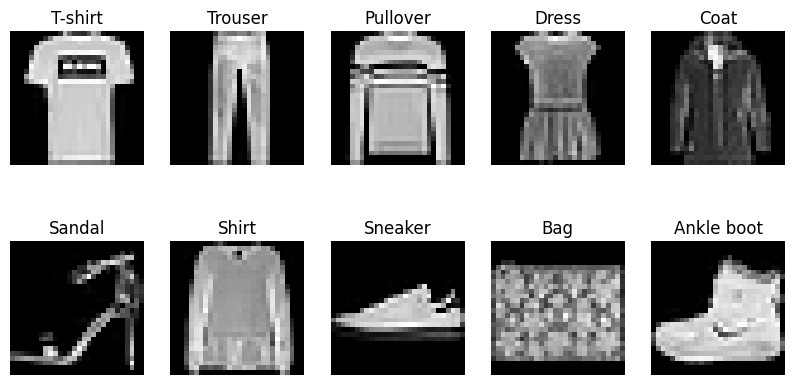

In [4]:
# Display one sample per class
classes = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    sample_idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[sample_idx].reshape(28, 28), cmap="gray")
    ax.set_title(classes[i])
    ax.axis("off")
plt.show()

# Log images to wandb
# wandb.log({"Fashion-MNIST Samples": [wandb.Image(X_train[np.where(y_train == i)[0][0]].reshape(28, 28), caption=classes[i]) for i in range(10)]})

In [5]:
# Activation Functions
def sigmoid(x, derivative=False):
    sig = 1 / (1 + np.exp(-x))
    return sig * (1 - sig) if derivative else sig

def tanh(x, derivative=False):
    t = np.tanh(x)
    return 1 - t**2 if derivative else t

def relu(x, derivative=False):
    return np.where(x > 0, 1, 0) if derivative else np.maximum(0, x)


# Weight Initialization
def init_weights(layers, method="random"):
    np.random.seed(42)
    weights = []
    biases = []
    for i in range(len(layers) - 1):
        if method == "Xavier":
            limit = np.sqrt(6 / (layers[i] + layers[i+1]))
            w = np.random.uniform(-limit, limit, (layers[i], layers[i+1]))
        else:
            w = np.random.randn(layers[i], layers[i+1]) * 0.01
        b = np.zeros((1, layers[i+1]))
        weights.append(w)
        biases.append(b)
    return weights, biases


# Forward Propagation
def forward_propagation(X, weights, biases, activation="relu"):
    activations = [X]
    zs = []
    for w, b in zip(weights, biases):
        z = np.dot(activations[-1], w) + b
        zs.append(z)
        activations.append(
            relu(z) if activation == "relu" else tanh(z) if activation == "tanh" else sigmoid(z)
        )
    return activations, zs


# Backpropagation
def backward_propagation(y_true, activations, zs, weights, learning_rate, activation="relu"):
    grads_w, grads_b = [], []
    m = y_true.shape[0]

    # Compute loss gradient
    dA = activations[-1] - y_true  # Cross-entropy derivative

    for i in reversed(range(len(weights))):
        dz = dA * (
            relu(zs[i], derivative=True) if activation == "relu" else
            tanh(zs[i], derivative=True) if activation == "tanh" else
            sigmoid(zs[i], derivative=True)
        )
        dw = np.dot(activations[i].T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        dA = np.dot(dz, weights[i].T)

        grads_w.insert(0, dw)
        grads_b.insert(0, db)

    return grads_w, grads_b


# Optimizers
class Optimizer:
    def __init__(self, method="sgd", lr=0.01, beta=0.9, beta2=0.999, epsilon=1e-8):
        self.method = method
        self.lr = lr
        self.beta = beta
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def update(self, weights, biases, grads_w, grads_b):
        if self.method == "sgd":
            return [w - self.lr * dw for w, dw in zip(weights, grads_w)], \
                   [b - self.lr * db for b, db in zip(biases, grads_b)]

        if self.method in ["momentum", "nesterov"]:
            if self.m is None:
                self.m = [np.zeros_like(w) for w in weights]

            for i in range(len(weights)):
                self.m[i] = self.beta * self.m[i] + self.lr * grads_w[i]
                weights[i] -= self.m[i] if self.method == "momentum" else self.beta * self.m[i] + self.lr * grads_w[i]

        if self.method in ["adam", "nadam", "rmsprop"]:
            if self.m is None:
                self.m = [np.zeros_like(w) for w in weights]
                self.v = [np.zeros_like(w) for w in weights]

            self.t += 1
            for i in range(len(weights)):
                self.m[i] = self.beta * self.m[i] + (1 - self.beta) * grads_w[i]
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grads_w[i] ** 2)
                m_hat = self.m[i] / (1 - self.beta**self.t)
                v_hat = self.v[i] / (1 - self.beta2**self.t)
                weights[i] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

        return weights, biases


# # Training
# def train(X, y, layers, epochs=10, batch_size=32, optimizer="sgd", activation="relu"):
#     weights, biases = init_weights(layers)
#     opt = Optimizer(method=optimizer, lr=0.001)

#     for epoch in range(epochs):
#         for i in range(0, X.shape[0], batch_size):
#             X_batch = X[i:i+batch_size]
#             y_batch = y[i:i+batch_size]

#             activations, zs = forward_propagation(X_batch, weights, biases, activation)
#             grads_w, grads_b = backward_propagation(y_batch, activations, zs, weights, 0.001, activation)
#             weights, biases = opt.update(weights, biases, grads_w, grads_b)

#         # Logging to wandb
#         loss = np.mean(-y_batch * np.log(activations[-1] + 1e-8))  # Cross-entropy
#         wandb.log({"epoch": epoch + 1, "loss": loss})
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

In [ ]:
# import time
# def wandb_init():
#   try:
#      wandb.init(project="fashion-mnist-nn")
#      time.sleep(10)
#   except:
#      wandb.init(project="fashion-mnist-nn")


In [11]:
def train():
    # wandb_init()
    wandb.init(project="fashion-mnist-nn", entity = "vinyk-sd-indian-institute-of-technology-madras")
    config = wandb.config  # Get hyperparameters

    # Extract hyperparameters from config
    epochs = config.epochs
    hidden_layers = config.hidden_layers
    hidden_size = config.hidden_size
    weight_decay = config.weight_decay
    learning_rate = config.learning_rate
    optimizer = config.optimizer
    batch_size = config.batch_size
    weight_init = config.weight_init
    activation = config.activation

    # Initialize weights and biases
    layers = [784, config.hidden_size, 10]  # Input layer, Hidden layer, Output layer
    weights, biases = init_weights(layers, method=config.weight_init)

    # Initialize optimizer
    optimizer = Optimizer(method=optimizer, lr=config.learning_rate)

    for epoch in range(epochs):
        # Mini-batch gradient descent
        num_batches = len(X_train) // batch_size
        train_loss, train_acc = 0, 0

        for i in range(num_batches):
            start, end = i * batch_size, (i + 1) * batch_size
            X_batch, y_batch = X_train[start:end], y_train_one_hot[start:end]

            # Forward Propagation
            activations, zs = forward_propagation(X_batch, weights, biases, activation)
            preds = np.argmax(activations[-1], axis=1)
            y_true_labels = np.argmax(y_batch, axis=1)

            # Compute training loss and accuracy
            batch_loss = np.mean((activations[-1] - y_batch) ** 2)  # Mean Squared Error
            batch_acc = np.mean(preds == y_true_labels)

            train_loss += batch_loss
            train_acc += batch_acc

            # Backpropagation
            grads_w, grads_b = backward_propagation(y_batch, activations, zs, weights, config.learning_rate, activation)

            # Update weights
            weights, biases = optimizer.update(weights, biases, grads_w, grads_b)

        train_loss /= num_batches
        train_acc /= num_batches

        # **Validation Phase**
        val_activations, _ = forward_propagation(X_test, weights, biases, activation)
        val_preds = np.argmax(val_activations[-1], axis=1)
        val_true_labels = np.argmax(y_test_one_hot, axis=1)

        val_loss = np.mean((val_activations[-1] - y_test_one_hot) ** 2)  # Mean Squared Error
        val_acc = np.mean(val_preds == val_true_labels)

        # **Log Metrics to wandb**
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc
        })

        # Print Progress
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

In [12]:
sweep_config = {
    'method': 'bayes',  # Bayesian optimization for efficiency
    'metric': {'name': 'val_loss', 'goal': 'minimize'},  # Optimize for lowest validation loss
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="fashion-mnist-nn")
wandb.agent(sweep_id, train, count=20)  # Runs 20 different hyperparameter combinations

Create sweep with ID: 93mly8pj
Sweep URL: https://wandb.ai/vinyk-sd-indian-institute-of-technology-madras/fashion-mnist-nn/sweeps/93mly8pj


wandb: Agent Starting Run: gnhf5wp8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss: 0.0988, Train Acc: 0.1017, Val Loss: 0.0972, Val Acc: 0.1223
Epoch 2: Train Loss: 0.0958, Train Acc: 0.1799, Val Loss: 0.0945, Val Acc: 0.2337
Epoch 3: Train Loss: 0.0935, Train Acc: 0.3069, Val Loss: 0.0925, Val Acc: 0.3441
Epoch 4: Train Loss: 0.0918, Train Acc: 0.3386, Val Loss: 0.0911, Val Acc: 0.3213
Epoch 5: Train Loss: 0.0906, Train Acc: 0.3139, Val Loss: 0.0901, Val Acc: 0.3059


epoch,▁▃▅▆█
train_accuracy,▁▃▇█▇
train_loss,█▅▄▂▁
val_accuracy,▁▅█▇▇
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.31392
train_loss,0.09057
val_accuracy,0.3059
val_loss,0.0901


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6aype742 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0945, Train Acc: 0.0999, Val Loss: 0.0904, Val Acc: 0.1000
Epoch 2: Train Loss: 0.0903, Train Acc: 0.1144, Val Loss: 0.0902, Val Acc: 0.1216
Epoch 3: Train Loss: 0.0898, Train Acc: 0.2029, Val Loss: 0.0893, Val Acc: 0.1988
Epoch 4: Train Loss: 0.0880, Train Acc: 0.2095, Val Loss: 0.0862, Val Acc: 0.2219
Epoch 5: Train Loss: 0.0835, Train Acc: 0.2388, Val Loss: 0.0807, Val Acc: 0.3124
Epoch 6: Train Loss: 0.0779, Train Acc: 0.3518, Val Loss: 0.0751, Val Acc: 0.4057
Epoch 7: Train Loss: 0.0724, Train Acc: 0.4395, Val Loss: 0.0700, Val Acc: 0.4771
Epoch 8: Train Loss: 0.0676, Train Acc: 0.5096, Val Loss: 0.0654, Val Acc: 0.5421
Epoch 9: Train Loss: 0.0632, Train Acc: 0.5584, Val Loss: 0.0612, Val Acc: 0.5703
Epoch 10: Train Loss: 0.0589, Train Acc: 0.5873, Val Loss: 0.0571, Val Acc: 0.5993


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▃▃▅▆▇██
train_loss,█▇▇▇▆▅▄▃▂▁
val_accuracy,▁▁▂▃▄▅▆▇██
val_loss,███▇▆▅▄▃▂▁
epoch,10
train_accuracy,0.58725
train_loss,0.05892
val_accuracy,0.5993
val_loss,0.05711


wandb: Agent Starting Run: mhsv7ewd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss: 0.0954, Train Acc: 0.2098, Val Loss: 0.0912, Val Acc: 0.3379
Epoch 2: Train Loss: 0.0888, Train Acc: 0.4153, Val Loss: 0.0870, Val Acc: 0.4777
Epoch 3: Train Loss: 0.0857, Train Acc: 0.5303, Val Loss: 0.0846, Val Acc: 0.5656
Epoch 4: Train Loss: 0.0835, Train Acc: 0.5908, Val Loss: 0.0825, Val Acc: 0.5972
Epoch 5: Train Loss: 0.0814, Train Acc: 0.6124, Val Loss: 0.0805, Val Acc: 0.6109
Epoch 6: Train Loss: 0.0794, Train Acc: 0.6210, Val Loss: 0.0785, Val Acc: 0.6171
Epoch 7: Train Loss: 0.0775, Train Acc: 0.6233, Val Loss: 0.0767, Val Acc: 0.6192
Epoch 8: Train Loss: 0.0758, Train Acc: 0.6234, Val Loss: 0.0751, Val Acc: 0.6168
Epoch 9: Train Loss: 0.0742, Train Acc: 0.6227, Val Loss: 0.0736, Val Acc: 0.6161
Epoch 10: Train Loss: 0.0729, Train Acc: 0.6216, Val Loss: 0.0724, Val Acc: 0.6166


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇██████
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▄▇▇██████
val_loss,█▆▆▅▄▃▃▂▁▁
epoch,10
train_accuracy,0.62155
train_loss,0.07287
val_accuracy,0.6166
val_loss,0.07235


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2lb736aw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0932, Train Acc: 0.1310, Val Loss: 0.0870, Val Acc: 0.1984
Epoch 2: Train Loss: 0.0793, Train Acc: 0.3898, Val Loss: 0.0665, Val Acc: 0.6772
Epoch 3: Train Loss: 0.0549, Train Acc: 0.7253, Val Loss: 0.0457, Val Acc: 0.7743
Epoch 4: Train Loss: 0.0389, Train Acc: 0.7909, Val Loss: 0.0345, Val Acc: 0.7988
Epoch 5: Train Loss: 0.0305, Train Acc: 0.8248, Val Loss: 0.0291, Val Acc: 0.8233


epoch,▁▃▅▆█
train_accuracy,▁▄▇██
train_loss,█▆▄▂▁
val_accuracy,▁▆▇██
val_loss,█▆▃▂▁
epoch,5
train_accuracy,0.82479
train_loss,0.03052
val_accuracy,0.8233
val_loss,0.0291


wandb: Agent Starting Run: mnd9xis5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0352, Train Acc: 0.7849, Val Loss: 0.0288, Val Acc: 0.8264
Epoch 2: Train Loss: 0.0257, Train Acc: 0.8474, Val Loss: 0.0265, Val Acc: 0.8397
Epoch 3: Train Loss: 0.0239, Train Acc: 0.8572, Val Loss: 0.0254, Val Acc: 0.8455
Epoch 4: Train Loss: 0.0229, Train Acc: 0.8623, Val Loss: 0.0248, Val Acc: 0.8477
Epoch 5: Train Loss: 0.0222, Train Acc: 0.8655, Val Loss: 0.0243, Val Acc: 0.8495
Epoch 6: Train Loss: 0.0218, Train Acc: 0.8674, Val Loss: 0.0240, Val Acc: 0.8516
Epoch 7: Train Loss: 0.0214, Train Acc: 0.8697, Val Loss: 0.0238, Val Acc: 0.8528
Epoch 8: Train Loss: 0.0211, Train Acc: 0.8714, Val Loss: 0.0237, Val Acc: 0.8535
Epoch 9: Train Loss: 0.0209, Train Acc: 0.8726, Val Loss: 0.0236, Val Acc: 0.8543
Epoch 10: Train Loss: 0.0207, Train Acc: 0.8743, Val Loss: 0.0235, Val Acc: 0.8541


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.8743
train_loss,0.02066
val_accuracy,0.8541
val_loss,0.02351


wandb: Agent Starting Run: nr83qeh6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0932, Train Acc: 0.1310, Val Loss: 0.0870, Val Acc: 0.1984
Epoch 2: Train Loss: 0.0793, Train Acc: 0.3898, Val Loss: 0.0665, Val Acc: 0.6772
Epoch 3: Train Loss: 0.0549, Train Acc: 0.7253, Val Loss: 0.0457, Val Acc: 0.7743
Epoch 4: Train Loss: 0.0389, Train Acc: 0.7909, Val Loss: 0.0345, Val Acc: 0.7988
Epoch 5: Train Loss: 0.0305, Train Acc: 0.8248, Val Loss: 0.0291, Val Acc: 0.8233
Epoch 6: Train Loss: 0.0263, Train Acc: 0.8393, Val Loss: 0.0263, Val Acc: 0.8309
Epoch 7: Train Loss: 0.0240, Train Acc: 0.8466, Val Loss: 0.0248, Val Acc: 0.8376
Epoch 8: Train Loss: 0.0226, Train Acc: 0.8535, Val Loss: 0.0239, Val Acc: 0.8405
Epoch 9: Train Loss: 0.0217, Train Acc: 0.8579, Val Loss: 0.0233, Val Acc: 0.8434
Epoch 10: Train Loss: 0.0210, Train Acc: 0.8613, Val Loss: 0.0228, Val Acc: 0.8462


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▇▇██████
train_loss,█▇▄▃▂▂▁▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▆▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.86129
train_loss,0.02103
val_accuracy,0.8462
val_loss,0.02283


wandb: Agent Starting Run: 2htctq77 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0329, Train Acc: 0.8014, Val Loss: 0.0285, Val Acc: 0.8276
Epoch 2: Train Loss: 0.0248, Train Acc: 0.8540, Val Loss: 0.0258, Val Acc: 0.8459
Epoch 3: Train Loss: 0.0229, Train Acc: 0.8653, Val Loss: 0.0245, Val Acc: 0.8544
Epoch 4: Train Loss: 0.0217, Train Acc: 0.8725, Val Loss: 0.0237, Val Acc: 0.8587
Epoch 5: Train Loss: 0.0209, Train Acc: 0.8774, Val Loss: 0.0233, Val Acc: 0.8608
Epoch 6: Train Loss: 0.0203, Train Acc: 0.8810, Val Loss: 0.0231, Val Acc: 0.8626
Epoch 7: Train Loss: 0.0198, Train Acc: 0.8841, Val Loss: 0.0229, Val Acc: 0.8633
Epoch 8: Train Loss: 0.0194, Train Acc: 0.8866, Val Loss: 0.0227, Val Acc: 0.8648
Epoch 9: Train Loss: 0.0191, Train Acc: 0.8885, Val Loss: 0.0225, Val Acc: 0.8647
Epoch 10: Train Loss: 0.0188, Train Acc: 0.8903, Val Loss: 0.0224, Val Acc: 0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.89026
train_loss,0.01879
val_accuracy,0.8657
val_loss,0.02237


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0a6ja2kk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0329, Train Acc: 0.8014, Val Loss: 0.0285, Val Acc: 0.8276
Epoch 2: Train Loss: 0.0248, Train Acc: 0.8540, Val Loss: 0.0258, Val Acc: 0.8459
Epoch 3: Train Loss: 0.0229, Train Acc: 0.8653, Val Loss: 0.0245, Val Acc: 0.8544
Epoch 4: Train Loss: 0.0217, Train Acc: 0.8725, Val Loss: 0.0237, Val Acc: 0.8587
Epoch 5: Train Loss: 0.0209, Train Acc: 0.8774, Val Loss: 0.0233, Val Acc: 0.8608
Epoch 6: Train Loss: 0.0203, Train Acc: 0.8810, Val Loss: 0.0231, Val Acc: 0.8626
Epoch 7: Train Loss: 0.0198, Train Acc: 0.8841, Val Loss: 0.0229, Val Acc: 0.8633
Epoch 8: Train Loss: 0.0194, Train Acc: 0.8866, Val Loss: 0.0227, Val Acc: 0.8648
Epoch 9: Train Loss: 0.0191, Train Acc: 0.8885, Val Loss: 0.0225, Val Acc: 0.8647
Epoch 10: Train Loss: 0.0188, Train Acc: 0.8903, Val Loss: 0.0224, Val Acc: 0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.89026
train_loss,0.01879
val_accuracy,0.8657
val_loss,0.02237


wandb: Agent Starting Run: zngzv311 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0308, Train Acc: 0.8157, Val Loss: 0.0271, Val Acc: 0.8332
Epoch 2: Train Loss: 0.0238, Train Acc: 0.8585, Val Loss: 0.0254, Val Acc: 0.8460
Epoch 3: Train Loss: 0.0221, Train Acc: 0.8693, Val Loss: 0.0244, Val Acc: 0.8504
Epoch 4: Train Loss: 0.0211, Train Acc: 0.8752, Val Loss: 0.0238, Val Acc: 0.8550
Epoch 5: Train Loss: 0.0204, Train Acc: 0.8794, Val Loss: 0.0235, Val Acc: 0.8583
Epoch 6: Train Loss: 0.0198, Train Acc: 0.8826, Val Loss: 0.0233, Val Acc: 0.8604
Epoch 7: Train Loss: 0.0194, Train Acc: 0.8861, Val Loss: 0.0232, Val Acc: 0.8607
Epoch 8: Train Loss: 0.0190, Train Acc: 0.8889, Val Loss: 0.0230, Val Acc: 0.8612
Epoch 9: Train Loss: 0.0187, Train Acc: 0.8912, Val Loss: 0.0228, Val Acc: 0.8625
Epoch 10: Train Loss: 0.0185, Train Acc: 0.8934, Val Loss: 0.0226, Val Acc: 0.8628


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
train_accuracy,0.89337
train_loss,0.01846
val_accuracy,0.8628
val_loss,0.02263


wandb: Agent Starting Run: 2w7lbkay with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0329, Train Acc: 0.8014, Val Loss: 0.0285, Val Acc: 0.8276
Epoch 2: Train Loss: 0.0248, Train Acc: 0.8540, Val Loss: 0.0258, Val Acc: 0.8459
Epoch 3: Train Loss: 0.0229, Train Acc: 0.8653, Val Loss: 0.0245, Val Acc: 0.8544
Epoch 4: Train Loss: 0.0217, Train Acc: 0.8725, Val Loss: 0.0237, Val Acc: 0.8587
Epoch 5: Train Loss: 0.0209, Train Acc: 0.8774, Val Loss: 0.0233, Val Acc: 0.8608
Epoch 6: Train Loss: 0.0203, Train Acc: 0.8810, Val Loss: 0.0231, Val Acc: 0.8626
Epoch 7: Train Loss: 0.0198, Train Acc: 0.8841, Val Loss: 0.0229, Val Acc: 0.8633
Epoch 8: Train Loss: 0.0194, Train Acc: 0.8866, Val Loss: 0.0227, Val Acc: 0.8648
Epoch 9: Train Loss: 0.0191, Train Acc: 0.8885, Val Loss: 0.0225, Val Acc: 0.8647
Epoch 10: Train Loss: 0.0188, Train Acc: 0.8903, Val Loss: 0.0224, Val Acc: 0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.89026
train_loss,0.01879
val_accuracy,0.8657
val_loss,0.02237


wandb: Agent Starting Run: j2x9in51 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0550, Train Acc: 0.6111, Val Loss: 0.0307, Val Acc: 0.8019
Epoch 2: Train Loss: 0.0255, Train Acc: 0.8343, Val Loss: 0.0243, Val Acc: 0.8364
Epoch 3: Train Loss: 0.0217, Train Acc: 0.8541, Val Loss: 0.0225, Val Acc: 0.8464
Epoch 4: Train Loss: 0.0201, Train Acc: 0.8655, Val Loss: 0.0216, Val Acc: 0.8534
Epoch 5: Train Loss: 0.0190, Train Acc: 0.8730, Val Loss: 0.0208, Val Acc: 0.8574
Epoch 6: Train Loss: 0.0182, Train Acc: 0.8782, Val Loss: 0.0203, Val Acc: 0.8604
Epoch 7: Train Loss: 0.0175, Train Acc: 0.8830, Val Loss: 0.0198, Val Acc: 0.8640
Epoch 8: Train Loss: 0.0170, Train Acc: 0.8869, Val Loss: 0.0194, Val Acc: 0.8669
Epoch 9: Train Loss: 0.0165, Train Acc: 0.8902, Val Loss: 0.0190, Val Acc: 0.8680
Epoch 10: Train Loss: 0.0160, Train Acc: 0.8938, Val Loss: 0.0188, Val Acc: 0.8699


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.89376
train_loss,0.01604
val_accuracy,0.8699
val_loss,0.01878


wandb: Agent Starting Run: tzrxm9ab with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0321, Train Acc: 0.8130, Val Loss: 0.0281, Val Acc: 0.8325
Epoch 2: Train Loss: 0.0241, Train Acc: 0.8588, Val Loss: 0.0265, Val Acc: 0.8439
Epoch 3: Train Loss: 0.0219, Train Acc: 0.8714, Val Loss: 0.0256, Val Acc: 0.8513
Epoch 4: Train Loss: 0.0206, Train Acc: 0.8791, Val Loss: 0.0248, Val Acc: 0.8565
Epoch 5: Train Loss: 0.0198, Train Acc: 0.8844, Val Loss: 0.0243, Val Acc: 0.8595
Epoch 6: Train Loss: 0.0191, Train Acc: 0.8890, Val Loss: 0.0239, Val Acc: 0.8631
Epoch 7: Train Loss: 0.0186, Train Acc: 0.8925, Val Loss: 0.0236, Val Acc: 0.8661
Epoch 8: Train Loss: 0.0182, Train Acc: 0.8959, Val Loss: 0.0234, Val Acc: 0.8682
Epoch 9: Train Loss: 0.0178, Train Acc: 0.8987, Val Loss: 0.0233, Val Acc: 0.8695
Epoch 10: Train Loss: 0.0175, Train Acc: 0.9013, Val Loss: 0.0231, Val Acc: 0.8700


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.90128
train_loss,0.01745
val_accuracy,0.87
val_loss,0.02312


wandb: Agent Starting Run: f5jw7yce with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0329, Train Acc: 0.8014, Val Loss: 0.0285, Val Acc: 0.8276
Epoch 2: Train Loss: 0.0248, Train Acc: 0.8540, Val Loss: 0.0258, Val Acc: 0.8459
Epoch 3: Train Loss: 0.0229, Train Acc: 0.8653, Val Loss: 0.0245, Val Acc: 0.8544
Epoch 4: Train Loss: 0.0217, Train Acc: 0.8725, Val Loss: 0.0237, Val Acc: 0.8587
Epoch 5: Train Loss: 0.0209, Train Acc: 0.8774, Val Loss: 0.0233, Val Acc: 0.8608


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87742
train_loss,0.02089
val_accuracy,0.8608
val_loss,0.02335


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jds262a6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0321, Train Acc: 0.8130, Val Loss: 0.0281, Val Acc: 0.8325
Epoch 2: Train Loss: 0.0241, Train Acc: 0.8588, Val Loss: 0.0265, Val Acc: 0.8439
Epoch 3: Train Loss: 0.0219, Train Acc: 0.8714, Val Loss: 0.0256, Val Acc: 0.8513
Epoch 4: Train Loss: 0.0206, Train Acc: 0.8791, Val Loss: 0.0248, Val Acc: 0.8565
Epoch 5: Train Loss: 0.0198, Train Acc: 0.8844, Val Loss: 0.0243, Val Acc: 0.8595


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.88442
train_loss,0.01978
val_accuracy,0.8595
val_loss,0.02427


wandb: Agent Starting Run: 0473dbbs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0329, Train Acc: 0.8014, Val Loss: 0.0285, Val Acc: 0.8276
Epoch 2: Train Loss: 0.0248, Train Acc: 0.8540, Val Loss: 0.0258, Val Acc: 0.8459
Epoch 3: Train Loss: 0.0229, Train Acc: 0.8653, Val Loss: 0.0245, Val Acc: 0.8544
Epoch 4: Train Loss: 0.0217, Train Acc: 0.8725, Val Loss: 0.0237, Val Acc: 0.8587
Epoch 5: Train Loss: 0.0209, Train Acc: 0.8774, Val Loss: 0.0233, Val Acc: 0.8608
Epoch 6: Train Loss: 0.0203, Train Acc: 0.8810, Val Loss: 0.0231, Val Acc: 0.8626
Epoch 7: Train Loss: 0.0198, Train Acc: 0.8841, Val Loss: 0.0229, Val Acc: 0.8633
Epoch 8: Train Loss: 0.0194, Train Acc: 0.8866, Val Loss: 0.0227, Val Acc: 0.8648
Epoch 9: Train Loss: 0.0191, Train Acc: 0.8885, Val Loss: 0.0225, Val Acc: 0.8647
Epoch 10: Train Loss: 0.0188, Train Acc: 0.8903, Val Loss: 0.0224, Val Acc: 0.8657


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.89026
train_loss,0.01879
val_accuracy,0.8657
val_loss,0.02237


wandb: Agent Starting Run: 2ldeij6j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0550, Train Acc: 0.6111, Val Loss: 0.0307, Val Acc: 0.8019
Epoch 2: Train Loss: 0.0255, Train Acc: 0.8343, Val Loss: 0.0243, Val Acc: 0.8364
Epoch 3: Train Loss: 0.0217, Train Acc: 0.8541, Val Loss: 0.0225, Val Acc: 0.8464
Epoch 4: Train Loss: 0.0201, Train Acc: 0.8655, Val Loss: 0.0216, Val Acc: 0.8534
Epoch 5: Train Loss: 0.0190, Train Acc: 0.8730, Val Loss: 0.0208, Val Acc: 0.8574


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▃▂▂▁
epoch,5
train_accuracy,0.87297
train_loss,0.01903
val_accuracy,0.8574
val_loss,0.02084


wandb: Agent Starting Run: 3hiuxz2z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0321, Train Acc: 0.8130, Val Loss: 0.0281, Val Acc: 0.8325
Epoch 2: Train Loss: 0.0241, Train Acc: 0.8588, Val Loss: 0.0265, Val Acc: 0.8439
Epoch 3: Train Loss: 0.0219, Train Acc: 0.8714, Val Loss: 0.0256, Val Acc: 0.8513
Epoch 4: Train Loss: 0.0206, Train Acc: 0.8791, Val Loss: 0.0248, Val Acc: 0.8565
Epoch 5: Train Loss: 0.0198, Train Acc: 0.8844, Val Loss: 0.0243, Val Acc: 0.8595


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.88442
train_loss,0.01978
val_accuracy,0.8595
val_loss,0.02427


wandb: Agent Starting Run: 8p2y4biy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0810, Train Acc: 0.3370, Val Loss: 0.0556, Val Acc: 0.6860
Epoch 2: Train Loss: 0.0395, Train Acc: 0.7600, Val Loss: 0.0315, Val Acc: 0.8015
Epoch 3: Train Loss: 0.0273, Train Acc: 0.8296, Val Loss: 0.0263, Val Acc: 0.8289
Epoch 4: Train Loss: 0.0237, Train Acc: 0.8451, Val Loss: 0.0243, Val Acc: 0.8373
Epoch 5: Train Loss: 0.0220, Train Acc: 0.8543, Val Loss: 0.0233, Val Acc: 0.8418
Epoch 6: Train Loss: 0.0210, Train Acc: 0.8600, Val Loss: 0.0226, Val Acc: 0.8462
Epoch 7: Train Loss: 0.0202, Train Acc: 0.8646, Val Loss: 0.0221, Val Acc: 0.8492
Epoch 8: Train Loss: 0.0197, Train Acc: 0.8687, Val Loss: 0.0217, Val Acc: 0.8510
Epoch 9: Train Loss: 0.0192, Train Acc: 0.8715, Val Loss: 0.0214, Val Acc: 0.8536
Epoch 10: Train Loss: 0.0188, Train Acc: 0.8748, Val Loss: 0.0211, Val Acc: 0.8548


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇███████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.8748
train_loss,0.01875
val_accuracy,0.8548
val_loss,0.02114


wandb: Agent Starting Run: rec8rcxw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0420, Train Acc: 0.7070, Val Loss: 0.0258, Val Acc: 0.8252
Epoch 2: Train Loss: 0.0223, Train Acc: 0.8495, Val Loss: 0.0225, Val Acc: 0.8479
Epoch 3: Train Loss: 0.0200, Train Acc: 0.8647, Val Loss: 0.0211, Val Acc: 0.8564
Epoch 4: Train Loss: 0.0186, Train Acc: 0.8748, Val Loss: 0.0203, Val Acc: 0.8603
Epoch 5: Train Loss: 0.0177, Train Acc: 0.8820, Val Loss: 0.0197, Val Acc: 0.8639
Epoch 6: Train Loss: 0.0170, Train Acc: 0.8869, Val Loss: 0.0192, Val Acc: 0.8674
Epoch 7: Train Loss: 0.0164, Train Acc: 0.8919, Val Loss: 0.0189, Val Acc: 0.8706
Epoch 8: Train Loss: 0.0158, Train Acc: 0.8954, Val Loss: 0.0186, Val Acc: 0.8736
Epoch 9: Train Loss: 0.0154, Train Acc: 0.8990, Val Loss: 0.0184, Val Acc: 0.8755
Epoch 10: Train Loss: 0.0149, Train Acc: 0.9022, Val Loss: 0.0182, Val Acc: 0.8764


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.90218
train_loss,0.01494
val_accuracy,0.8764
val_loss,0.01824


wandb: Agent Starting Run: xya0c9sd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss: 0.0420, Train Acc: 0.7070, Val Loss: 0.0258, Val Acc: 0.8252
Epoch 2: Train Loss: 0.0223, Train Acc: 0.8495, Val Loss: 0.0225, Val Acc: 0.8479
Epoch 3: Train Loss: 0.0200, Train Acc: 0.8647, Val Loss: 0.0211, Val Acc: 0.8564
